# 1.Import Libraries and Load Data



In [194]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [195]:


columns = [
    "serial_number", "activity_date", "facility_name", "score", "grade",
    "service_code", "service_description", "employee_id", "facility_address",
    "facility_city", "facility_id", "facility_state", "facility_zip", "owner_id",
    "owner_name", "pe_description", "program_element_pe", "program_name",
    "program_status", "record_id"
]

df = pd.read_csv("Restaurant_and_Market_Health_Inspections_VF.csv", usecols=columns)
df.shape
df.head()


,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,facility_id,facility_state,facility_zip,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id
0,DAJ00E07B,12/29/2017 12:00:00 AM,HABITAT COFFEE SHOP,95.0,A,1.0,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,FA0170465,CA,90065,OW0178123,NaN,RESTAURANT (0-30) SEATS MODERATE RISK,1631.0,HABITAT COFFEE SHOP,ACTIVE,PR0160774
1,DAQOKRFZB,12/29/2017 12:00:00 AM,REILLY'S,NaN,A,1.0,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,FA0244690,CA,NaN,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631.0,REILLY'S,ACTIVE,PR0193026
2,DASJI4LUR,12/29/2017 12:00:00 AM,STREET CHURROS,93.0,NaN,1.0,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,FA0224109,CA,90028,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630.0,STREET CHURROS,ACTIVE,PR0179282
3,DA40LU5AT,12/29/2017 12:00:00 AM,TRINITI ECHO PARK,94.0,A,1.0,ROUTINE INSPECTION,EE0000923,1814 W SUNSET BLVD,LOS ANGELES,FA0252528,CA,90026-3227,OW0246287,NaN,RESTAURANT (0-30) SEATS MODERATE RISK,1631.0,NaN,ACTIVE,PR0201836
4,DAXV2RMYC,12/29/2017 12:00:00 AM,POLLEN,94.0,A,1.0,ROUTINE INSPECTION,EE0000923,2100 ECHO PARK AVE,LOS ANGELES,NaN,CA,90026,OW0246479,"POLLEN AND PASTRY , LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631.0,POLLEN,ACTIVE,PR0202148


In [196]:
# Define regex patterns for extracting the values from pe_description
facility_type_pattern = r'([^\(]+)'  # Capture everything before the first parenthesis
capacity_pattern = r'(\([^\)]*\))'   # Capture everything inside the parentheses
risk_pattern = r'(\bHIGH\b|\bMODERATE\b|\bLOW\b)'  # Capture HIGH, MODERATE, or LOW after the parentheses
# Apply the regex patterns to extract the data into separate columns
df['FACILITY_TYPE'] = df['pe_description'].str.extract(facility_type_pattern)
df['CAPACITY'] = df['pe_description'].str.extract(capacity_pattern)
df['RISK'] = df['pe_description'].str.extract(risk_pattern)
# For rows where RISK is not one of HIGH, MODERATE, or LOW, set it as NaN
df['RISK'] = df['RISK'].apply(lambda x: x if x in ['HIGH', 'MODERATE', 'LOW'] else np.nan)



In [197]:
# Define the mappings for restaurant and non-restaurant facilities
restaurant_mapping = {
    ('(0-30)', 'LOW'): 1630, ('(0-30)', 'MODERATE'): 1631, ('(0-30)', 'HIGH'): 1632,
    ('(31-60)', 'LOW'): 1633, ('(31-60)', 'MODERATE'): 1634, ('(31-60)', 'HIGH'): 1635,
    ('(61-150)', 'LOW'): 1636, ('(61-150)', 'MODERATE'): 1637, ('(61-150)', 'HIGH'): 1638,
    ('(151 + )', 'LOW'): 1639, ('(151 + )', 'MODERATE'): 1640, ('(151 + )', 'HIGH'): 1641
}

mkt_mapping = {
    ('(1-1,999 SF)', 'LOW'): 1610, ('(1-1,999 SF)', 'MODERATE'): 1611, ('(1-1,999 SF)', 'HIGH'): 1612,
    ('(2,000+ SF)', 'LOW'): 1613, ('(2,000+ SF)', 'MODERATE'): 1614, ('(2,000+ SF)', 'HIGH'): 1615
}

# Function to fill missing values
def fill_missing_values(df):
    for index, row in df.iterrows():
        # If program_element_pe is missing, we use RISK, CAPACITY, and FACILITY_TYPE to fill it
        if pd.isna(row['program_element_pe']):
            if pd.notna(row['RISK']) and pd.notna(row['CAPACITY']) and pd.notna(row['FACILITY_TYPE']):
                # Check if it is a restaurant or not
                if row['FACILITY_TYPE'] == 'RESTAURANT':
                    # Use restaurant mapping
                    key = (row['CAPACITY'], row['RISK'])
                    if key in restaurant_mapping:
                        df.at[index, 'program_element_pe'] = restaurant_mapping[key]
                else:
                    # Use market mapping
                    key = (row['CAPACITY'], row['RISK'])
                    if key in mkt_mapping:
                        df.at[index, 'program_element_pe'] = mkt_mapping[key]

        # If RISK, CAPACITY, or FACILITY_TYPE is missing, we use program_element_pe to deduce them
        if pd.isna(row['RISK']) or pd.isna(row['CAPACITY']) or pd.isna(row['FACILITY_TYPE']):
            if pd.notna(row['program_element_pe']):
                # Check if program_element_pe corresponds to a restaurant or market
                if row['program_element_pe'] in restaurant_mapping.values():
                    # Deduce RISK and CAPACITY from restaurant_mapping
                    for (cap, risk), pe in restaurant_mapping.items():
                        if pe == row['program_element_pe']:
                            df.at[index, 'CAPACITY'] = cap
                            df.at[index, 'RISK'] = risk
                            df.at[index, 'FACILITY_TYPE'] = 'RESTAURANT'
                            break
                elif row['program_element_pe'] in mkt_mapping.values():
                    # Deduce RISK and CAPACITY from market_mapping
                    for (cap, risk), pe in mkt_mapping.items():
                        if pe == row['program_element_pe']:
                            df.at[index, 'CAPACITY'] = cap
                            df.at[index, 'RISK'] = risk
                            df.at[index, 'FACILITY_TYPE'] = 'MKT'
                            break
    return df

# Apply the function to fill the missing values
df = fill_missing_values(df)

# Show the updated DataFrame
print(df[['program_element_pe', 'RISK', 'CAPACITY', 'FACILITY_TYPE']])



       program_element_pe      RISK     CAPACITY     FACILITY_TYPE
0                  1631.0  MODERATE       (0-30)       RESTAURANT 
1                  1631.0  MODERATE       (0-30)       RESTAURANT 
2                  1630.0       LOW       (0-30)       RESTAURANT 
3                  1631.0  MODERATE       (0-30)       RESTAURANT 
4                  1631.0  MODERATE       (0-30)       RESTAURANT 
...                   ...       ...          ...               ...
67568              1635.0      HIGH      (31-60)       RESTAURANT 
67569              1613.0       LOW  (2,000+ SF)  FOOD MKT RETAIL 
67570              1615.0      HIGH  (2,000+ SF)  FOOD MKT RETAIL 
67571              1635.0      HIGH      (31-60)       RESTAURANT 
67572              1631.0  MODERATE       (0-30)       RESTAURANT 

[67573 rows x 4 columns]


In [198]:
df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,FACILITY_TYPE,CAPACITY,RISK
0,DAJ00E07B,12/29/2017 12:00:00 AM,HABITAT COFFEE SHOP,95.0,A,1.0,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,OW0178123,NaN,RESTAURANT (0-30) SEATS MODERATE RISK,1631.0,HABITAT COFFEE SHOP,ACTIVE,PR0160774,RESTAURANT,(0-30),MODERATE
1,DAQOKRFZB,12/29/2017 12:00:00 AM,REILLY'S,NaN,A,1.0,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631.0,REILLY'S,ACTIVE,PR0193026,RESTAURANT,(0-30),MODERATE
2,DASJI4LUR,12/29/2017 12:00:00 AM,STREET CHURROS,93.0,NaN,1.0,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630.0,STREET CHURROS,ACTIVE,PR0179282,RESTAURANT,(0-30),LOW
3,DA40LU5AT,12/29/2017 12:00:00 AM,TRINITI ECHO PARK,94.0,A,1.0,ROUTINE INSPECTION,EE0000923,1814 W SUNSET BLVD,LOS ANGELES,...,OW0246287,NaN,RESTAURANT (0-30) SEATS MODERATE RISK,1631.0,NaN,ACTIVE,PR0201836,RESTAURANT,(0-30),MODERATE
4,DAXV2RMYC,12/29/2017 12:00:00 AM,POLLEN,94.0,A,1.0,ROUTINE INSPECTION,EE0000923,2100 ECHO PARK AVE,LOS ANGELES,...,OW0246479,"POLLEN AND PASTRY , LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631.0,POLLEN,ACTIVE,PR0202148,RESTAURANT,(0-30),MODERATE


# Feature transformation

 **Data Cleaning**

In [199]:
# Handle missing values (for simplicity, we can drop rows with missing target columns)
df.dropna(subset=['score','RISK','FACILITY_TYPE','CAPACITY'], inplace=True)

In [200]:
df.isnull().sum()

,0
serial_number,4478
activity_date,4487
facility_name,4443
score,0
grade,4359
service_code,4380
service_description,4321
employee_id,4369
facility_address,4434
facility_city,4230


**Encodage**

In [201]:
from sklearn.preprocessing import LabelEncoder

# Initialiser le LabelEncoder
encoder = LabelEncoder()

# Encoder les valeurs de la colonne 'RISK'
df['RISK'] = encoder.fit_transform(df['RISK'])

# Vérifier les valeurs encodées
print(df['RISK'].unique())

[2 1 0]


In [202]:
# Initialiser le LabelEncoder
encoder = LabelEncoder()

# Encoder les valeurs de la colonne 'FACILITY_TYPE'
df['FACILITY_TYPE'] = encoder.fit_transform(df['FACILITY_TYPE'])

# Vérifier les valeurs encodées
print(df['FACILITY_TYPE'].unique())

[4 0 3 2 1]


In [203]:
# Initialiser le LabelEncoder
encoder = LabelEncoder()

# Appliquer l'encodage sur la colonne 'CAPACITY'
df['CAPACITY'] = encoder.fit_transform(df['CAPACITY'])
# Vérifier les valeurs uniques après l'encodage
print(df['CAPACITY'].unique())

[0 3 8 6 2 1 5 7 4]


In [204]:
features = df[['score','RISK','FACILITY_TYPE','CAPACITY']]  # Add more features if necessary

In [205]:
features.head()

,score,RISK,FACILITY_TYPE,CAPACITY
0,95.0,2,4,0
2,93.0,1,4,0
3,94.0,2,4,0
4,94.0,2,4,0
6,95.0,1,0,3


# Exploratory Data Analysis (EDA)

**Correlation Heatmap**

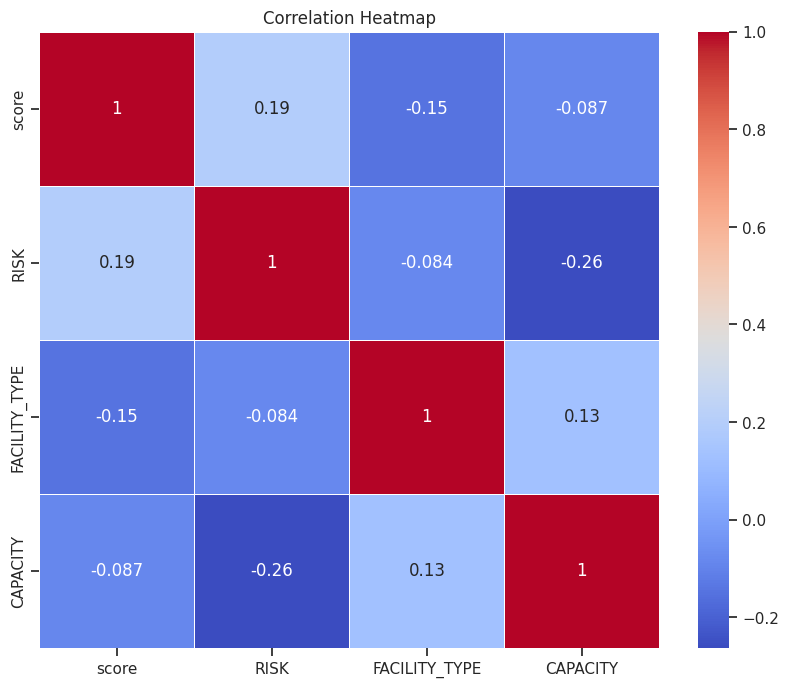

In [206]:
correlation = features.corr()

# Afficher la carte thermique
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

**Boxplots**

Visualized the distribution and outliers for key features.



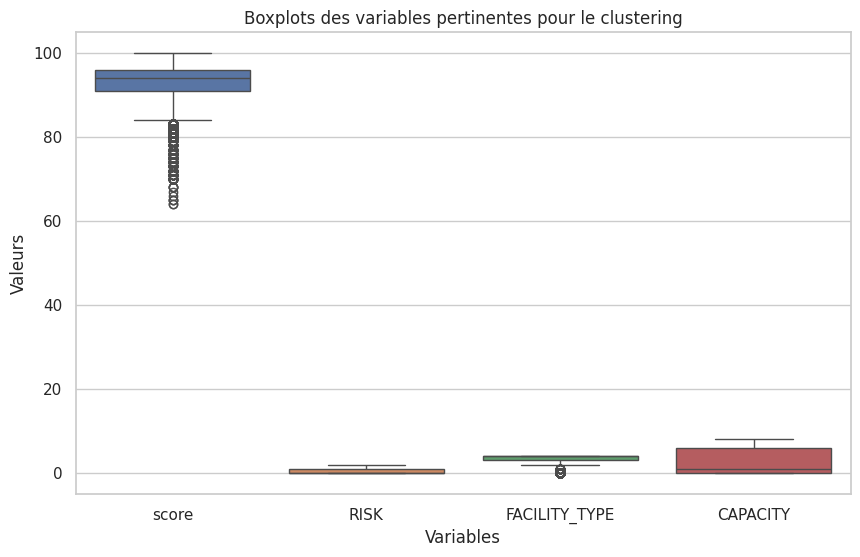

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner les colonnes pertinentes sans 'points' et 'CAPACITY'
columns_to_plot = ['score','RISK','FACILITY_TYPE','CAPACITY']

# Vérifier si les colonnes sont disponibles
if all(col in df.columns for col in columns_to_plot):
    # Créer un DataFrame des colonnes sélectionnées
    data_to_plot = df[columns_to_plot].dropna()

    # Tracer les boxplots
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data_to_plot)
    plt.title('Boxplots des variables pertinentes pour le clustering')
    plt.xlabel('Variables')
    plt.ylabel('Valeurs')
    plt.show()
else:
    print("Les colonnes sélectionnées ne sont pas toutes présentes dans le DataFrame.")







#**Boxplots for Relevant Variables**:
   - **Observation**: Boxplots illustrate the distribution of key variables (`score`, `RISK`, `FACILITY_TYPE`, `CAPACITY`) used in clustering.
   - **Key Points**:
     - The `score` variable has a wide range, with some outliers indicating low-performing facilities.
     - Variables like `RISK` and `FACILITY_TYPE` show much smaller ranges, highlighting their potential uniformity or categorical nature.
     - `CAPACITY` has moderate variability, indicating diverse facility sizes.
   - **Link to Model**:
     - These boxplots help identify variables with significant variability (`score`, `CAPACITY`) that influence clustering, while uniform variables like `RISK` might help differentiate clusters when combined with others.



**Scatter Matrix**

Explored feature distributions.

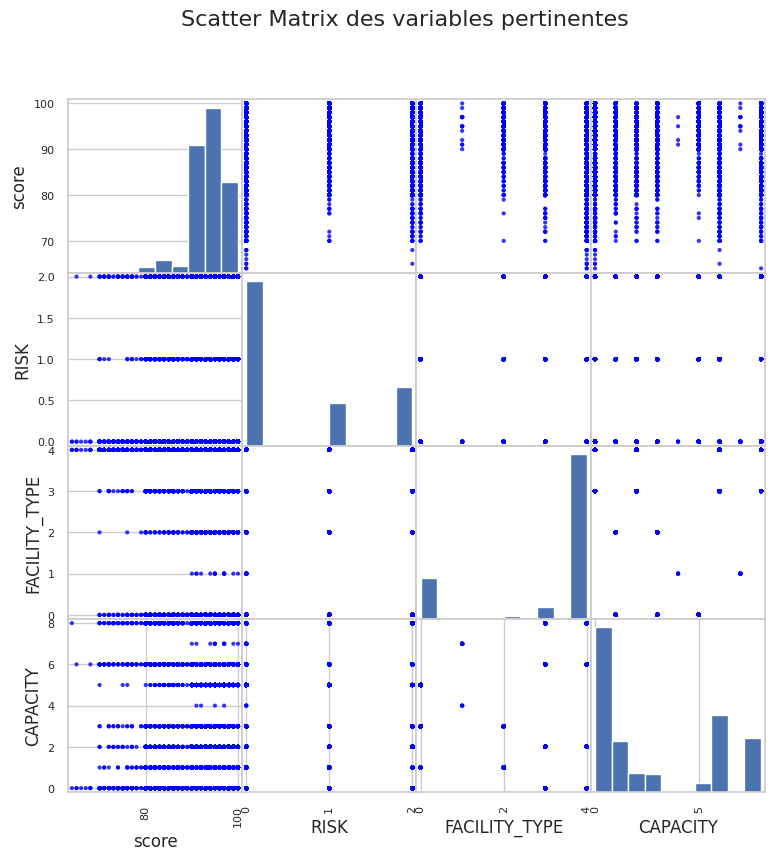

In [208]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Sélectionner les colonnes pertinentes
columns_to_plot = ['score','RISK','FACILITY_TYPE','CAPACITY']

# Vérifier si les colonnes sont disponibles
if all(col in df.columns for col in columns_to_plot):
    # Créer une matrice de dispersion pour les colonnes sélectionnées
    scatter_matrix(df[columns_to_plot], figsize=(9, 9), alpha=0.8, diagonal='hist', color='blue')
    plt.suptitle("Scatter Matrix des variables pertinentes", fontsize=16)
    plt.show()
else:
    print("Les colonnes sélectionnées ne sont pas toutes présentes dans le DataFrame.")

**Pairplot Using Seaborn**

The pairplot shows scatter plots for all feature combinations and includes a density plot on the diagonal.

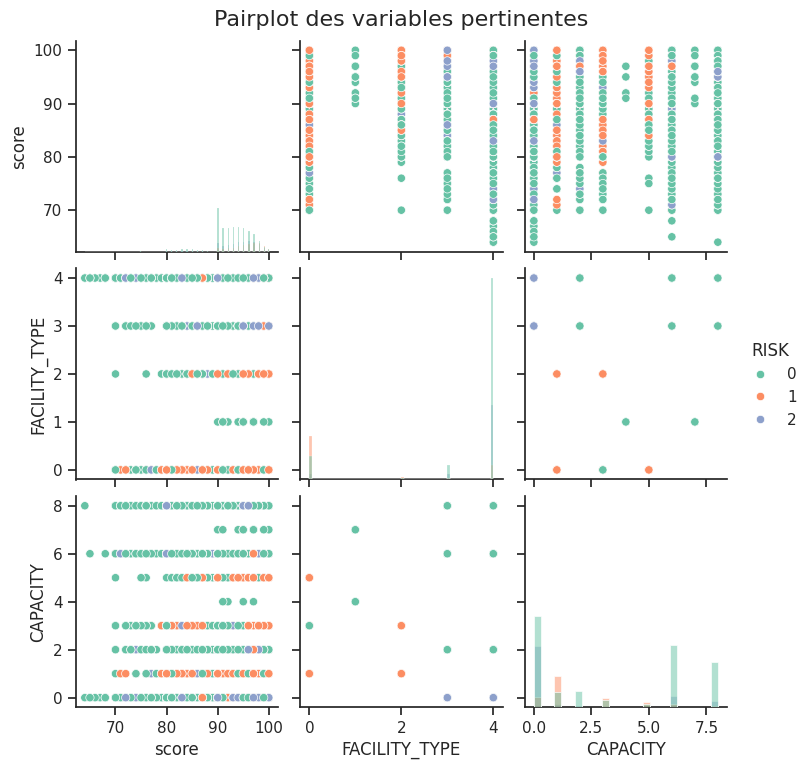

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner les colonnes pertinentes
columns_to_plot = ['score','RISK','FACILITY_TYPE','CAPACITY']
# Vérifier si les colonnes sont disponibles
if all(col in df.columns for col in columns_to_plot):
    # Créer un pairplot avec une variable catégorique pour le paramètre hue
    sns.set(style="ticks")
    pairplot = sns.pairplot(df[columns_to_plot], hue='RISK', palette='Set2', diag_kind='hist', height=2.5)
    pairplot.fig.suptitle("Pairplot des variables pertinentes", y=1.02, fontsize=16)
    plt.show()
else:
    print("Les colonnes sélectionnées ne sont pas toutes présentes dans le DataFrame.")



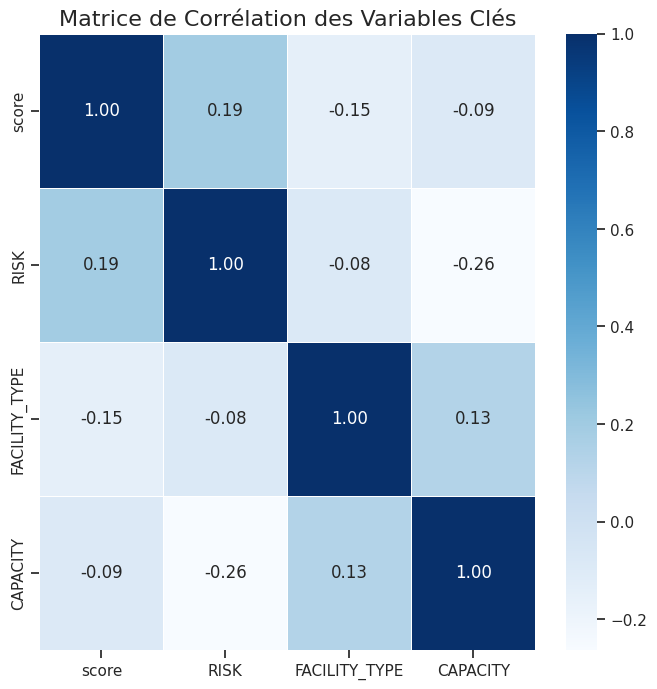

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner les colonnes pertinentes pour la corrélation
columns_to_correlate = ['score','RISK','FACILITY_TYPE','CAPACITY']

# Vérifier si les colonnes sont disponibles
if all(col in df.columns for col in columns_to_correlate):
    # Calculer la matrice de corrélation
    correlations = df[columns_to_correlate].corr()

    # Tracer la heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(correlations, annot=True, cmap="Blues", linewidths=0.5, fmt=".2f")
    plt.title("Matrice de Corrélation des Variables Clés", fontsize=16)
    plt.show()
else:
    print("Les colonnes sélectionnées ne sont pas toutes présentes dans le DataFrame.")

# Feature Scaling

In [211]:
from sklearn.preprocessing import StandardScaler

# Colonnes pertinentes pour le clustering
clustering_features = ['score','RISK','FACILITY_TYPE','CAPACITY']
clustering_data = df[clustering_features].dropna()

# Standardisation
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)


#Elbow Method for Optimal K

method to find the optimal number of clusters.

In [212]:
!pip install kneed

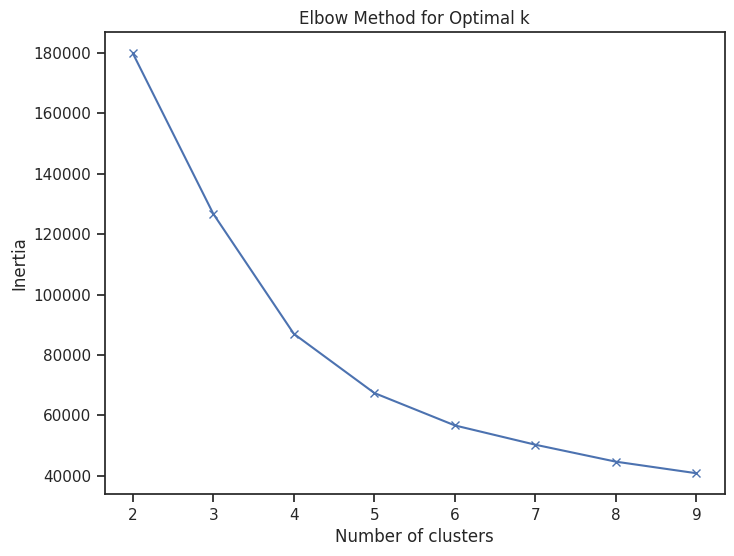

In [213]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Trouver le nombre optimal de clusters (Elbow Method)
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, init='random', n_init=10, random_state=42)
    kmeans.fit(clustering_data_scaled)
    inertias.append(kmeans.inertia_)

# Visualiser la méthode Elbow
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), inertias, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()



In [214]:
from kneed import KneeLocator
knee = KneeLocator(range(2, 10), inertias, curve="convex", direction="decreasing")
print(f"Nombre optimal de clusters : {knee.knee}")

Nombre optimal de clusters : 4


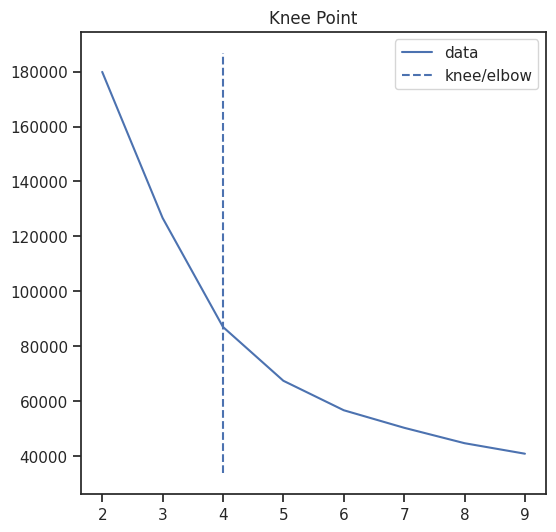

In [215]:
knee.plot_knee()
plt.show()

#  **K-Means Clustering Algorithm**

**K-Means Algorithm**

In [216]:
from sklearn.cluster import KMeans


# Create a KMeans instance with a specified number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)

# Fit the KMeans model to your scaled data and get cluster labels
clusters = kmeans.fit_predict(clustering_data_scaled)

# Create a copy of the features DataFrame to avoid modifying the original
selected_features = features.copy()

# Add the cluster labels to the selected_features DataFrame
# Use 'clusters' instead of 'labels' because it matches the length of selected_features
selected_features['cluster'] = clusters

# Merge the cluster labels back into the original DataFrame
data = df.merge(selected_features[['cluster']], left_index=True, right_index=True, how='left')

# Display the dataset with the cluster labels
print(data[['score', 'RISK','FACILITY_TYPE','CAPACITY', 'cluster']].head(20))

    score  RISK  FACILITY_TYPE  CAPACITY  cluster
0    95.0     2              4         0        1
2    93.0     1              4         0        1
3    94.0     2              4         0        1
4    94.0     2              4         0        1
6    95.0     1              0         3        1
7    91.0     0              4         8        0
8    95.0     0              4         0        0
9    91.0     2              4         0        1
10   95.0     0              4         6        0
11   97.0     0              4         6        0
12   95.0     0              4         0        0
13   90.0     0              4         8        0
14   90.0     2              4         0        1
15   92.0     2              4         0        1
16   98.0     1              4         0        1
17   97.0     0              4         8        0
18   85.0     1              0         3        1
19   97.0     0              4         0        0
20   92.0     0              3         8        0


**Visualize the clusters**

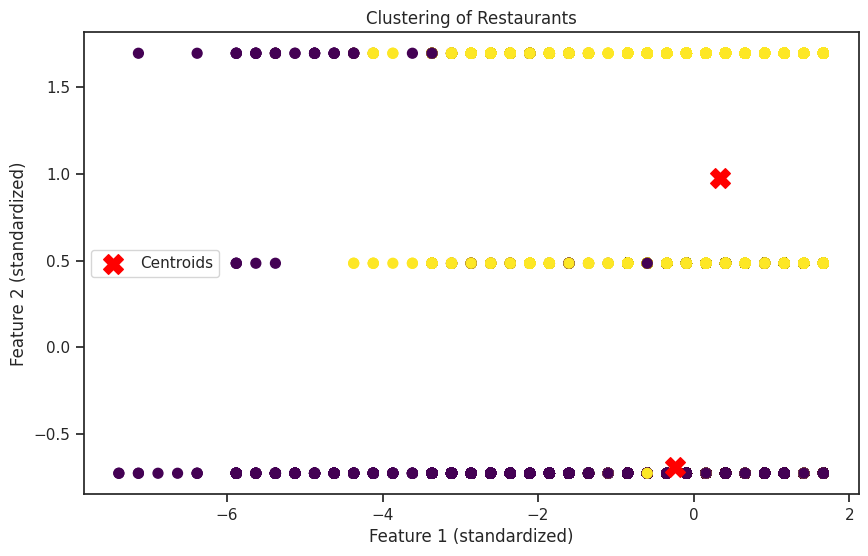

In [193]:

# Visualiser les clusters
plt.figure(figsize=(10, 6))
plt.scatter(clustering_data_scaled[:, 0], clustering_data_scaled[:, 1], c=clusters, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title("Clustering of Restaurants")
plt.xlabel("Feature 1 (standardized)")
plt.ylabel("Feature 2 (standardized)")
plt.legend()
plt.show()


# **PCA for Dimensionality Reduction**

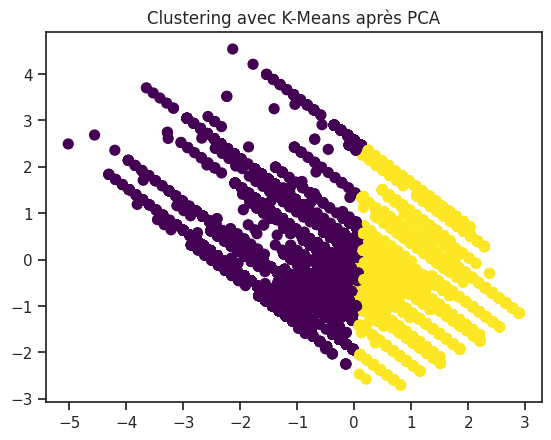

In [217]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler  # Import StandardScaler

# Assume you want to cluster based on these columns
clustering_columns =  ['score','RISK','FACILITY_TYPE','CAPACITY'] # Replace with your relevant columns
clustering_data = df[clustering_columns].dropna()

# Standardize the data (important for PCA)
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Réduction de la dimension
pca = PCA(n_components=2)
Z_reduced = pca.fit_transform(clustering_data_scaled) # Changed Z to clustering_data_scaled

# Clustering avec K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(Z_reduced)

# Ajout des clusters au DataFrame
df['Cluster'] = clusters

# Visualisation
plt.scatter(Z_reduced[:, 0], Z_reduced[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("Clustering avec K-Means après PCA")
plt.show()

**K-Means Visualization after PCA**  
- The **K-Means analysis** has divided the data into **two distinct clusters**.  
- **Cluster 0 (in purple):** Concentrated primarily around negative and near-zero scores after PCA dimensionality reduction. This indicates a group with lower or moderate performance or similar characteristics but in the lower range of values.  
- **Cluster 1 (in yellow):** Consists of points with positive scores, indicating a better overall profile based on the principal components.

#**K-Means Clustering Visualization after PCA**:
   - **Observation**: The scatter plot shows the clustering results after reducing the dimensionality using Principal Component Analysis (PCA). Each color represents a distinct cluster.
   - **Key Points**:
     - PCA reduces the dataset dimensions while preserving most variance, enabling better visualization.
     - Clusters appear well-separated, suggesting K-Means effectively segmented the data.
   - **Link to Model**:
     - The visualization confirms that the K-Means algorithm successfully identified distinct patterns in the data, which can be further used to group facilities with similar health risks or profiles.

# **Hierarchical Clustering**

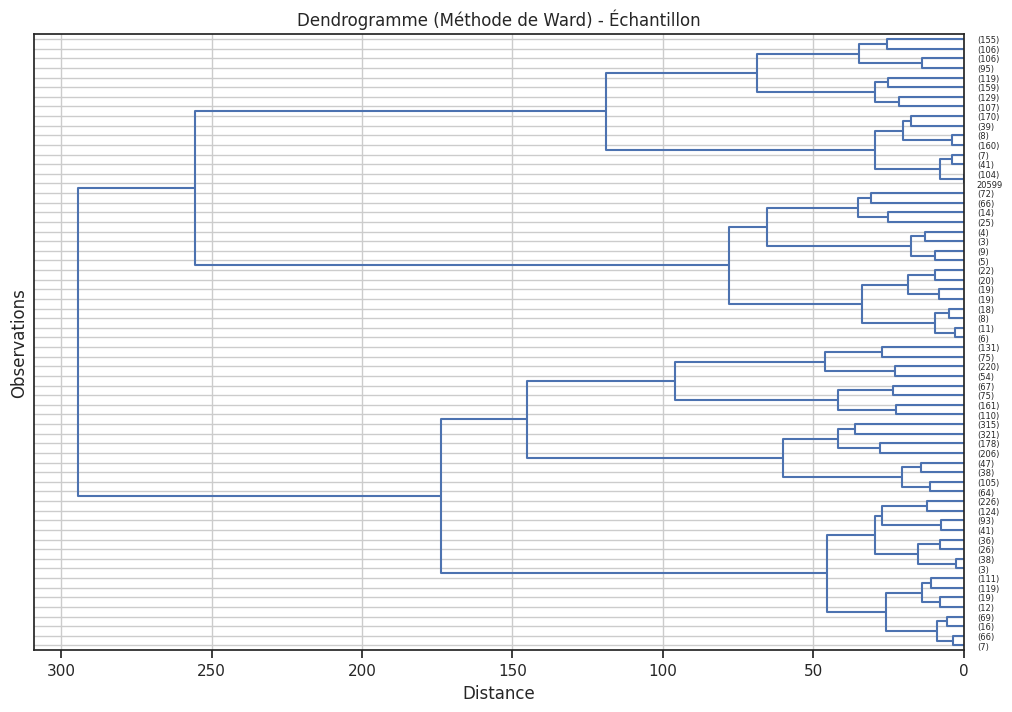

       score  RISK  FACILITY_TYPE  CAPACITY  Cluster
15411   94.0     2              4         0        1
60169   90.0     1              2         1        1
28857   92.0     1              0         5        1
3385    97.0     0              0         3        1
40227   95.0     0              4         8        2


In [218]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Étape 1 : Sélectionner les colonnes pertinentes
columns_to_cluster = ['score','RISK','FACILITY_TYPE','CAPACITY']

# Vérification que les colonnes nécessaires existent
if all(col in df.columns for col in columns_to_cluster):
    # Étape 2 : Préparer les données
    data_to_cluster = df[columns_to_cluster].dropna()  # Supprimer les valeurs manquantes

    # Échantillonner pour éviter MemoryError
    sampled_data = data_to_cluster.sample(n=5000, random_state=42)  # Ajustez 'n' si nécessaire

    # Étape 3 : Calculer le linkage
    linkage_matrix = linkage(sampled_data, method='ward', metric='euclidean')

    # Étape 4 : Tracer le dendrogramme
    plt.figure(figsize=(12, 8))
    dendrogram(
        linkage_matrix,
        truncate_mode='level',  # Limiter la profondeur pour plus de clarté
        p=5,  # Montrer les 5 derniers niveaux
        labels=sampled_data.index,  # Utiliser les indices des échantillons
        orientation='left',
        color_threshold=0  # Pas de seuil de couleur spécifique
    )
    plt.title("Dendrogramme (Méthode de Ward) - Échantillon")
    plt.xlabel("Distance")
    plt.ylabel("Observations")
    plt.grid(True)
    plt.show()

    # Étape 5 : Découper les clusters
    clusters = fcluster(linkage_matrix,2, criterion='maxclust')  # Découper en 't' clusters

    # Ajouter les clusters au DataFrame
    sampled_data['Cluster'] = clusters
    print(sampled_data.head())  # Afficher un aperçu des données échantillonnées avec leurs clusters

else:
    print("Les colonnes nécessaires pour le clustering ne sont pas toutes présentes dans le DataFrame.")


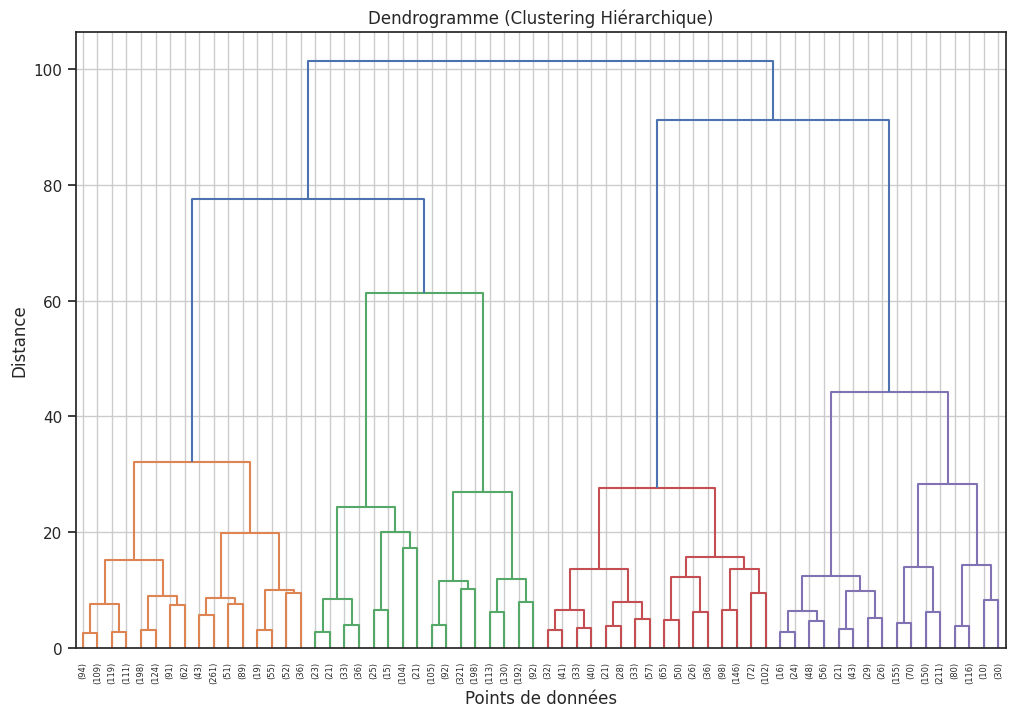

In [219]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import pandas as pd

# Étape 1 : Prétraitement des données
# Sélection des colonnes pertinentes pour le clustering
columns_to_cluster = ['score','RISK','FACILITY_TYPE','CAPACITY']

data_to_cluster = df[columns_to_cluster].dropna()  # Supprime les lignes avec des valeurs manquantes

# Normalisation des données
scaler = StandardScaler()
Z = scaler.fit_transform(data_to_cluster)

# Étape 2 : Réduction de l'échantillon pour éviter les erreurs de mémoire
sample_data = data_to_cluster.sample(n=5000, random_state=42)  # Échantillon de 5000 lignes
sample_Z = scaler.fit_transform(sample_data)

# Étape 3 : Calcul de la matrice de linkage
linkage_matrix = linkage(sample_Z, method='ward', metric='euclidean')

# Étape 4 : Tracer le dendrogramme
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Limite la profondeur pour plus de clarté
plt.title("Dendrogramme (Clustering Hiérarchique)")
plt.xlabel("Points de données")
plt.ylabel("Distance")
plt.grid(True)
plt.show()




#**Dendrogram (Clustering Hiérarchique)**:
   - **Observation**: The dendrogram provides a hierarchical visualization of the clustering process. Each merge represents a group of data points being clustered together at a specific distance threshold.
   - **Key Points**:
     - Clusters are formed by merging nodes at smaller distances first.
     - The distance on the y-axis indicates how similar (or dissimilar) the data points are.
   - **Link to Model**:
     - This dendrogram assists in deciding the optimal number of clusters for K-Means by analyzing the largest vertical gaps between merges. For instance, if a large vertical gap exists before two main clusters merge, it indicates an ideal cluster split.

**Visualize the distribution of features across the clusters**

<ipython-input-220-f75ca810daa6>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')
<ipython-input-220-f75ca810daa6>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')
<ipython-input-220-f75ca810daa6>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')
<ipython-input-220-f75ca810daa6>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. 

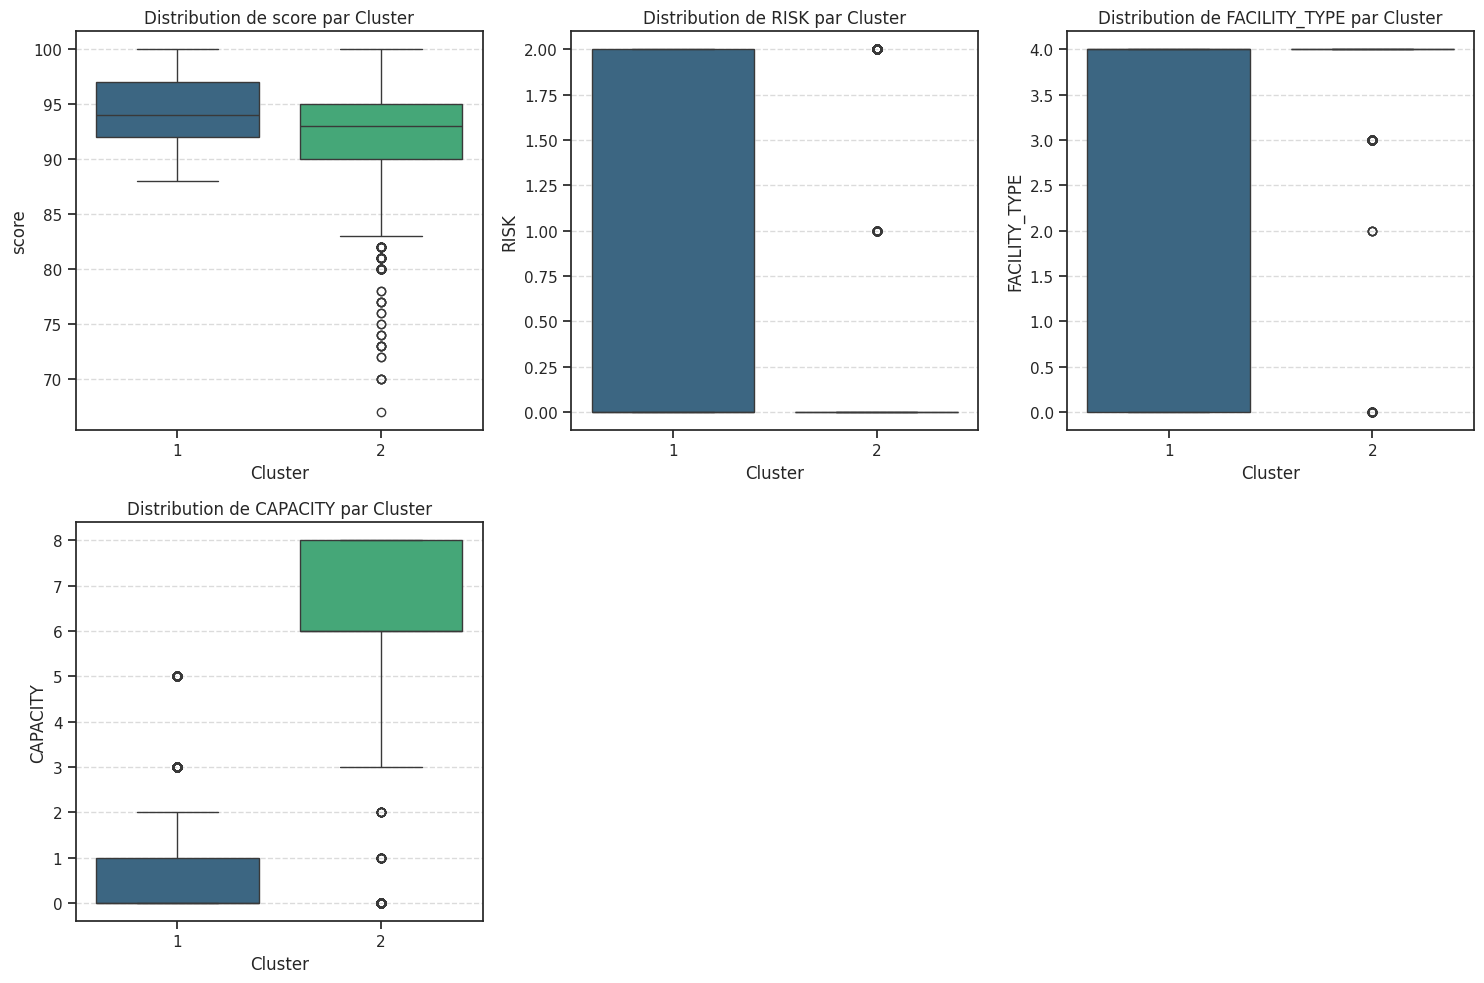

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Étape 1 : Préparer les données
# Assurez-vous que vos données contiennent une colonne 'Cluster'
# et les colonnes pertinentes pour les features
df = sampled_data.copy()  # Assurez-vous que cette variable est définie
df['Cluster'] = clusters  # Ajout des clusters (assurez-vous que 'clusters' est défini)

# Liste des colonnes à visualiser
features_to_plot = ['score','RISK','FACILITY_TYPE','CAPACITY'] # Ajoutez d'autres colonnes si nécessaire

# Étape 2 : Déterminer les dimensions de la grille
n_features = len(features_to_plot)
n_cols = 3  # Nombre de colonnes dans la grille
n_rows = math.ceil(n_features / n_cols)  # Calcul du nombre de lignes nécessaires

# Étape 3 : Créer les boxplots
plt.figure(figsize=(15, 5 * n_rows))  # Ajuster la taille de la figure
for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)  # Position dans la grille
    sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')
    plt.title(f'Distribution de {feature} par Cluster', fontsize=12)
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



---

### **1. Score Distribution**
- **Description:** The boxplot for the **score** shows the spread and central tendency of scores for each cluster.  
- **Interpretation:**  
   - **Cluster 0:**  
     - The median score is **lower** compared to Cluster 1.  
     - The spread is **wider**, suggesting that the scores vary significantly within this cluster.  
     - There are several outliers on the **lower end**, indicating some facilities with particularly poor scores.  
   - **Cluster 1:**  
     - The median score is **higher**, indicating that facilities in this cluster tend to perform better.  
     - The spread is **narrower**, suggesting a more consistent level of scores across facilities.  
     - Outliers are fewer compared to Cluster 0.  

- **Insight:** Facilities in **Cluster 1** generally have **better scores** and less variability, while facilities in **Cluster 0** show poorer and more inconsistent performance.

---

### **2. Risk Distribution**
- **Description:** This graph shows the risk distribution across both clusters.  
- **Interpretation:**  
   - **Cluster 0:**  
     - Facilities in this cluster exhibit **lower risk values**.  
     - The distribution is relatively compact, indicating that facilities in Cluster 0 have consistent, lower risks.  
   - **Cluster 1:**  
     - Facilities in this cluster have **higher risk values**.  
     - The spread is larger, indicating more variability in risk across facilities.  
     - The higher risk suggests that facilities in this cluster may require closer inspection or interventions.  

- **Insight:** **Cluster 1** contains facilities with higher and more variable risk levels, while **Cluster 0** is characterized by lower risk facilities.

---

### **3. Facility Type Distribution**
- **Description:** The graph for **facility type** (likely categorical) shows the frequency of each type in both clusters.  
- **Interpretation:**  
   - The **distribution of facility types** appears to be fairly similar in both clusters.  
   - No specific facility type seems to dominate one cluster over the other.  
   - If any differences exist, they are minor, meaning that **facility type does not strongly differentiate the clusters**.  

- **Insight:** Facility type does not seem to play a significant role in separating the clusters.

---

### **4. Capacity Distribution**
- **Description:** The boxplot for **capacity** shows how the facility sizes differ between clusters.  
- **Interpretation:**  
   - **Cluster 0:**  
     - Facilities tend to have **lower capacities**, meaning smaller establishments.  
     - The spread is narrower, suggesting that most facilities in Cluster 0 are consistently small.  
   - **Cluster 1:**  
     - Facilities generally have **larger capacities**, indicating larger establishments.  
     - The spread is wider, suggesting more variability in facility sizes.  

- **Insight:** **Cluster 1** contains larger facilities, while **Cluster 0** consists of smaller facilities. Larger facilities (Cluster 1) may explain the higher risk values observed earlier.

---

### **Overall Key Takeaways for Each Feature:**
1. **Score:**  
   - Cluster 1: Higher scores, more consistent.  
   - Cluster 0: Lower scores, more variability, and outliers.  

2. **Risk:**  
   - Cluster 1: Higher risks, more variable.  
   - Cluster 0: Lower risks, more consistent.  

3. **Facility Type:**  
   - No significant differences between clusters.  

4. **Capacity:**  
   - Cluster 1: Larger facilities.  
   - Cluster 0: Smaller facilities.  


# Prediction Analysis

In [221]:
cluster_status_comparison = data.groupby(['cluster', 'program_status']).size().unstack(fill_value=0)
print(cluster_status_comparison)


program_status  ACTIVE  INACTIVE
cluster                         
0                29160      4891
1                21430      2731


# Actionable Insights

In [222]:
# Actionable Insight based on clusters
for cluster in data['cluster'].unique():
    at_risk_facilities = data[data['cluster'] == cluster]
    print(f"\nFacilities in Cluster {cluster} require immediate inspection due to their status and risk levels.")
    print(at_risk_facilities[['facility_name', 'RISK', 'program_status']])


Facilities in Cluster 1 require immediate inspection due to their status and risk levels.
               facility_name  RISK program_status
0        HABITAT COFFEE SHOP     2         ACTIVE
2             STREET CHURROS     1         ACTIVE
3          TRINITI ECHO PARK     2         ACTIVE
4                     POLLEN     2         ACTIVE
6           7 ELEVEN #37215A     1         ACTIVE
...                      ...   ...            ...
67565       SEVEN DAY CHEVON     1         ACTIVE
67566      BIG DADDY'S SHACK     2         ACTIVE
67569            KANG WON DO     1         ACTIVE
67570           OASIS MARKET     0         ACTIVE
67572  SUPERIOR GROCERS #113     2         ACTIVE

[25935 rows x 3 columns]

Facilities in Cluster 0 require immediate inspection due to their status and risk levels.
                 facility_name  RISK program_status
7                          NaN     0         ACTIVE
8                     PHO LALA     0         ACTIVE
10                    UPSTAIRS     0



---

**Conclusion: Cluster Profiles**  
- **Cluster 0:**  
  - Comprised mainly of facilities with **lower scores** and **smaller capacity**.  
  - Low risk but requires monitoring to prevent further decline in performance.  

- **Cluster 1:**  
  - Shows **higher scores** and **larger capacity**, but is associated with **higher risk levels**.  
  - These facilities require **immediate inspection** to mitigate potential risks.  

---

### **Summary**  
- **Cluster 1** represents **critical facilities** with higher risk and performance variability that require prompt intervention.  
- **Cluster 0** consists of **lower-performing but stable facilities** that should be monitored for proactive improvement.

# **Export the Clustered Data:**

In [223]:
import pandas as pd

# Assuming `data` contains your dataset
# Adding the cluster labels if not already present
data['cluster'] = kmeans.labels_

# Select relevant columns
clustered_data = data[['facility_id','facility_name','score','RISK','FACILITY_TYPE','CAPACITY', 'program_status', 'cluster']]

# Export to CSV
clustered_data.to_csv("clustered_data.csv", index=False)

print("Clustered data exported successfully to clustered_data.csv.")


Clustered data exported successfully to clustered_data.csv.




# **Save the Model File**

In [224]:
import joblib

# Save the trained KMeans model
joblib.dump(kmeans, "kmeans_model.pkl")

print("KMeans model saved successfully as kmeans_model.pkl.")


KMeans model saved successfully as kmeans_model.pkl.


### **Integrated Conclusion from Analyses**

By synthesizing the observations from the dendrogram, clustering results, and feature-specific analyses (score, risk, facility type, and capacity), we can draw the following conclusions:

---

### **1. Cluster Profiles:**
- **Cluster 0**:
  - Facilities in this cluster tend to **perform worse** (lower median scores) and show greater variability, with some extreme outliers indicating very poor performance.
  - They are generally **lower-risk facilities** with consistent risk levels.
  - These facilities are **smaller establishments**, as evidenced by their lower capacities.
  - **Key Insight:** This cluster likely represents **smaller, low-risk facilities that need support to improve their inspection scores**. Their size may limit resources, contributing to the inconsistent and poorer performance.

- **Cluster 1**:
  - Facilities in this cluster tend to **perform better** (higher median scores) with less variability.
  - They exhibit **higher and more variable risks**, making them more critical to monitor and manage.
  - These facilities are generally **larger establishments**, which may explain their higher risk levels and greater variability.
  - **Key Insight:** This cluster represents **larger, higher-risk facilities that perform better overall but may require targeted interventions to reduce risk variability**.

---

### **2. Risk vs. Performance:**
- A **trade-off exists between facility size and risk**: Larger facilities (Cluster 1) tend to perform better but have higher and more variable risks. Smaller facilities (Cluster 0) have lower risks but struggle with performance consistency.
- This suggests that risk management strategies should differ between clusters:
  - **Cluster 0**: Focus on improving inspection scores through education, resource allocation, and standardized practices.
  - **Cluster 1**: Prioritize risk reduction and variability management through stricter compliance monitoring and targeted inspections.

---

### **3. Facility Type:**
- Facility type does not significantly influence clustering, suggesting that **other variables like size, risk, and performance are more important for differentiating clusters.**
- Future models could explore additional features or external factors (e.g., location, ownership patterns) for further insights.

---

### **4. General Observations:**
- The clustering approach effectively segmented facilities into meaningful groups with distinct characteristics.
- **Hierarchical clustering** was useful in determining the optimal number of clusters.
- **K-Means clustering** combined with PCA provided an interpretable visualization of facility groupings, confirming meaningful separations.

---

### **5. Actionable Recommendations:**
- For **Cluster 0** (low-performing, low-risk, smaller facilities):
  - Implement **training programs** for staff to improve compliance.
  - Provide **resource support** to address outliers with very low scores.
  - Focus on improving score consistency across facilities.

- For **Cluster 1** (better-performing, high-risk, larger facilities):
  - Strengthen **risk monitoring** protocols to address variability in risk.
  - Develop **tailored inspection plans** to ensure consistent compliance across larger establishments.
  - Encourage **investment in safety measures** to mitigate risks specific to high-capacity facilities.

---

### **Conclusion:**
The clustering analysis reveals a clear distinction between smaller, low-risk facilities needing support to improve performance and larger, high-risk facilities requiring enhanced risk management. These insights can guide targeted interventions to optimize inspection outcomes and resource allocation for better public health outcomes.